# **Importing Libraries**

In [75]:
pip install researchpy --quiet

In [76]:
import os
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import plotly.express as px
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import researchpy as rp
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score,f1_score, confusion_matrix , plot_confusion_matrix , accuracy_score , precision_score , recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import StratifiedShuffleSplit
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [77]:
pd.options.mode.chained_assignment = None  
pd.options.display.max_rows = 200
pd.options.display.max_columns = 150


# **Retriving Dataset**

In [78]:
data=pd.read_csv('/content/drive/MyDrive/Loan_data',low_memory=False)

data.dtype

# **Data Preprocessing**

In [79]:
data = data.drop(['Unnamed: 0','member_id'],axis = 1)

In [80]:
data.loan_status.value_counts()

Fully Paid                                             702354
Charged Off                                            268559
Late (31-120 days)                                      21467
In Grace Period                                          8436
Late (16-30 days)                                        4349
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                    40
Name: loan_status, dtype: int64

For the analysis only the Full Paid loans and the Charged Off/ Defaulted Loans have been taken into consideration.


In [81]:
Loan_Main = data.copy()

In [82]:
Loan_Main['loan_status'] =  np.where(Loan_Main['loan_status'].str.contains('Fully'),0,1)

In [83]:
Loan_Main.loan_status.value_counts()

0    704375
1    303612
Name: loan_status, dtype: int64

In [84]:
def emp_to_num(term):
    if pd.isna(term):
        return None
    elif term[2]=='+':
        return 10
    elif term[0]=='<':
        return 0
    else:
        return int(term[0])

Loan_Main['emp_length'] = Loan_Main['emp_length'].apply(emp_to_num)

In [85]:
nunique_val = Loan_Main.apply(pd.Series.nunique)
single_val_cols = nunique_val[nunique_val == 1].index.tolist()
single_val_cols

['policy_code', 'hardship_type', 'deferral_term', 'hardship_length']

Variance Threshold:

 For Categorical features: Any feature with same 1 category in the dataset would not provide any information the model. The features like 'policy_code', 'hardship_type', 'deferral_term', 'hardship_length'. Any feature with less variance would not be that useful for the model.

In [86]:
Loan_Main= Loan_Main.drop(single_val_cols, axis =1)

In [87]:
a=Loan_Main.isnull().sum()/len(Loan_Main)*100
variables = Loan_Main.columns
len(variables)

145

In [88]:
variable = [ ]
for i in range(0,len(variables)):
    if a[i]<50: 
        variable.append(variables[i])
 
drop_columns1=list(set(variables) - set(variable))
df_drop_nan=Loan_Main.drop(columns=drop_columns1)

Missing Data Threshold: 

Variables with more than 50% missing values were removed. (I.e., Around 58 variables were dropped/removed.)  

In [89]:
((df_drop_nan.isnull().sum()/len(df_drop_nan))*100).sort_values(ascending=False)

mths_since_recent_inq         13.839663
num_tl_120dpd_2m              10.542894
mo_sin_old_il_acct             9.771455
pct_tl_nvr_dlq                 6.990368
avg_cur_bal                    6.977372
mo_sin_rcnt_rev_tl_op          6.975288
mo_sin_old_rev_tl_op           6.975288
num_rev_accts                  6.975189
num_tl_30dpd                   6.975189
num_il_tl                      6.975189
num_bc_tl                      6.975189
num_rev_tl_bal_gt_0            6.975189
tot_coll_amt                   6.975189
tot_cur_bal                    6.975189
total_rev_hi_lim               6.975189
num_actv_rev_tl                6.975189
num_tl_90g_dpd_24m             6.975189
num_op_rev_tl                  6.975189
num_tl_op_past_12m             6.975189
num_actv_bc_tl                 6.975189
num_accts_ever_120_pd          6.975189
tot_hi_cred_lim                6.975189
total_il_high_credit_limit     6.975189
mo_sin_rcnt_tl                 6.975189
emp_title                      6.730940


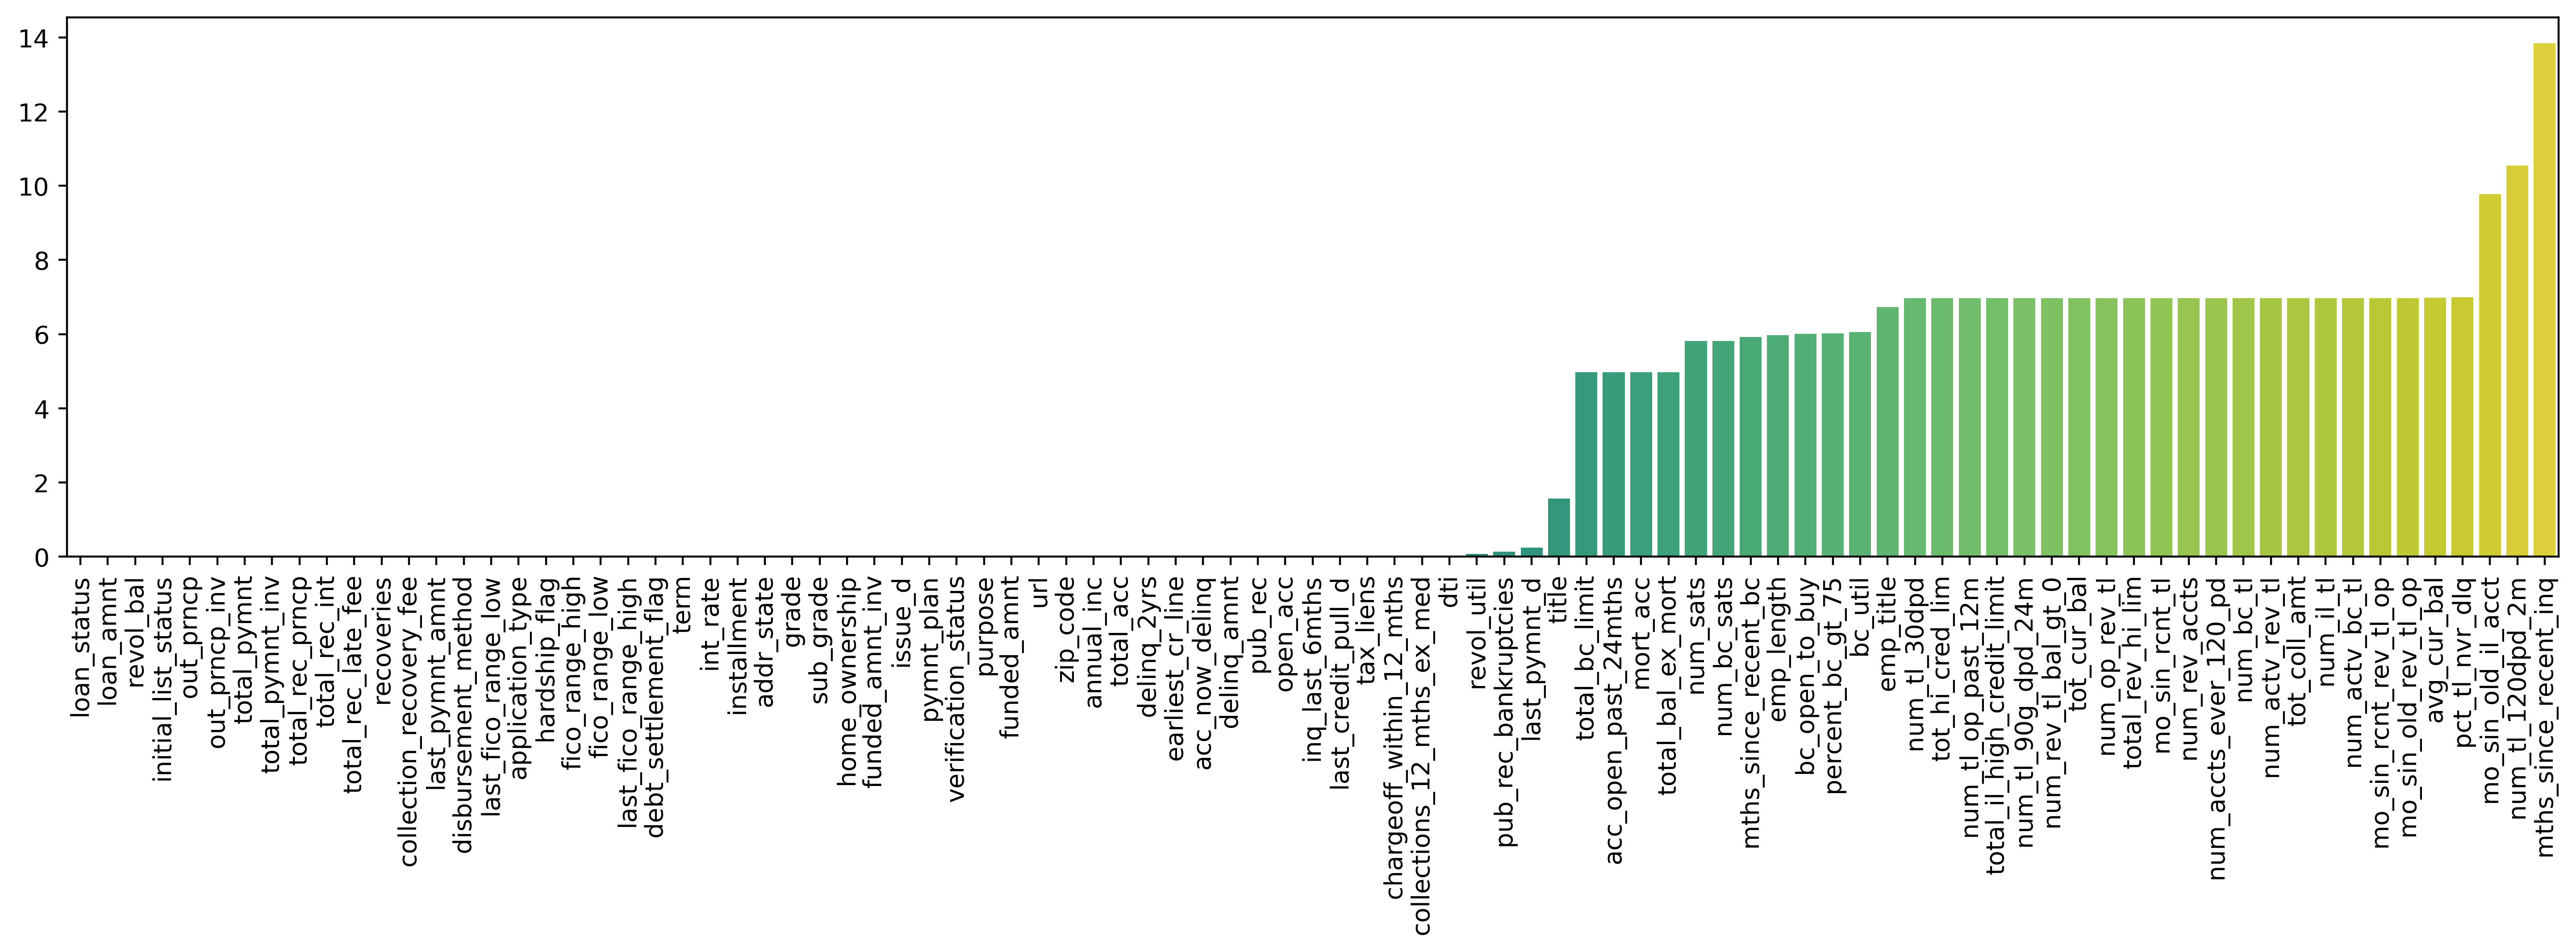

In [90]:
plt.figure(figsize=(18,4),dpi=400)
sns.barplot(y=((df_drop_nan.isnull().sum()/len(df_drop_nan))*100).sort_values(), x=((df_drop_nan.isnull().sum()/len(df_drop_nan))*100).sort_values().index, palette='viridis')
plt.xticks(rotation=90);

***Since we don't have a clear understanding for many features, it would be unwise to include them into our analysis without truly understanding a feature. \ Moreover, not all features will be available to us before a person gets loan. \ Some features will only be available after a person gets a loan. We have the following features we will be proceeding with the given features ***

In [91]:
final_features = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
                          'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
                          'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',"addr_state",
                          'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
                          'revol_util', 'total_acc', 'initial_list_status', 'application_type',
                          'mort_acc', 'pub_rec_bankruptcies','fico_range_low','fico_range_high']

In [92]:
df = df_drop_nan[final_features]

In [93]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,1007954.0,14548.746471,8773.824100,500.00,8000.00,12000.00,20000.00,40000.00
int_rate,1007954.0,13.807262,4.861595,5.31,10.49,13.35,16.59,30.99
installment,1007954.0,442.178182,263.362785,4.93,251.55,378.22,584.96,1719.83
emp_length,947757.0,5.946822,3.683302,0.00,2.00,6.00,10.00,10.00
annual_inc,1007950.0,75607.791317,68894.605344,0.00,45000.00,65000.00,90000.00,9573072.00
loan_status,1007987.0,0.301206,0.458782,0.00,0.00,0.00,1.00,1.00
dti,1007660.0,18.284156,11.142748,-1.00,11.80,17.63,24.04,999.00
open_acc,1007925.0,11.538216,5.437588,0.00,8.00,11.00,14.00,88.00
pub_rec,1007925.0,0.210961,0.598688,0.00,0.00,0.00,0.00,86.00
revol_bal,1007954.0,15989.252538,21620.998266,0.00,5923.00,11093.00,19559.00,2568995.00


In [94]:
df.describe( include= ["object"]).transpose()


,count,unique,top,freq
term,1007954,2,36 months,742600
grade,1007954,7,C,291510
sub_grade,1007954,35,C1,64103
emp_title,940140,318747,Teacher,14679
home_ownership,1007954,6,MORTGAGE,493347
verification_status,1007954,3,Source Verified,376052
issue_d,1007954,139,Mar-2016,49821
purpose,1007954,14,debt_consolidation,586759
title,992147,63146,Debt consolidation,466830
addr_state,1007954,51,CA,148254


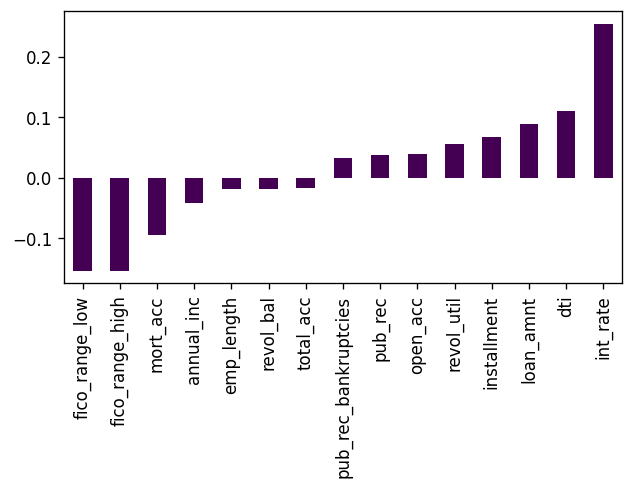

In [95]:
plt.figure(figsize=(6,3),dpi=120)
df.corr()['loan_status'].sort_values().drop('loan_status').plot(kind='bar', cmap='viridis') # correlation with loan_status for continuous features with loan_status feature dropped
plt.xticks(rotation=90); 

In [96]:
def create_countplot(axes, x_val,order_val, title, rotation="n"):
    sns.countplot(ax= axes, data=df, x=x_val, order = order_val.value_counts(dropna= False).index,hue = "loan_status")
    axes.set_title(title)
    if rotation =="y":
        axes.set_xticklabels(list(order_val.unique()), rotation=90)

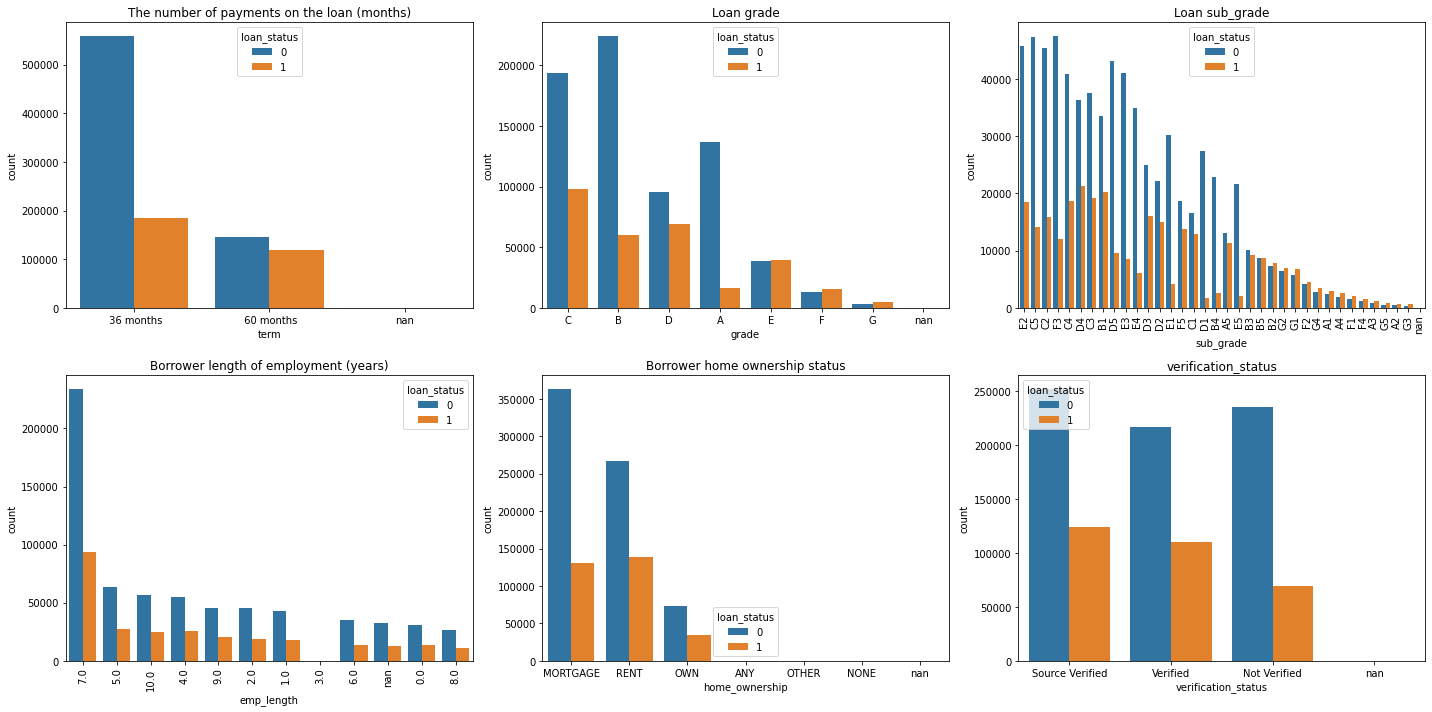

In [97]:
fig, ax = plt.subplots(2,3, figsize= (20,10))
create_countplot(ax[0,0],'term', df["term"],"The number of payments on the loan (months)" )
create_countplot(ax[0,1],'grade', df["grade"],"Loan grade")
create_countplot(ax[0,2],'sub_grade', df["sub_grade"],"Loan sub_grade","y")
create_countplot(ax[1,0],'emp_length', df["emp_length"],"Borrower length of employment (years)", "y" )
create_countplot(ax[1,1],'home_ownership', df["home_ownership"],"Borrower home ownership status" )
create_countplot(ax[1,2],'verification_status', df["verification_status"],"verification_status" )
plt.tight_layout()
plt.show()



In the Graph [0,0],

The no. of payments of loan is 36 months for most of the customers and the rest have 60 months. 

In 36 months, 24% of the customers are defaulting the loan, whereas in 60 months 45% of the customers are defaulting the loans. 

---
In Graph [0,1],

It is seen that as the Grade increases the Defaulters Rate also increases,
there is a linear relationship between grade and defaulters rate.

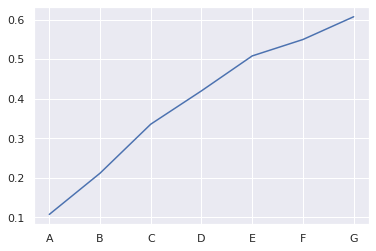

---









In Graph [0,1],

The initial listing Status consists of two types 

1.   Fractional denoted by f
2.   Whole denoted by w

The defaulters Rate is 0.32 for the the customer who were given the whole Loan amount, and the defaulters rate is 0.27 for the customers who where given loan amounts in Fractions(Installments)
.


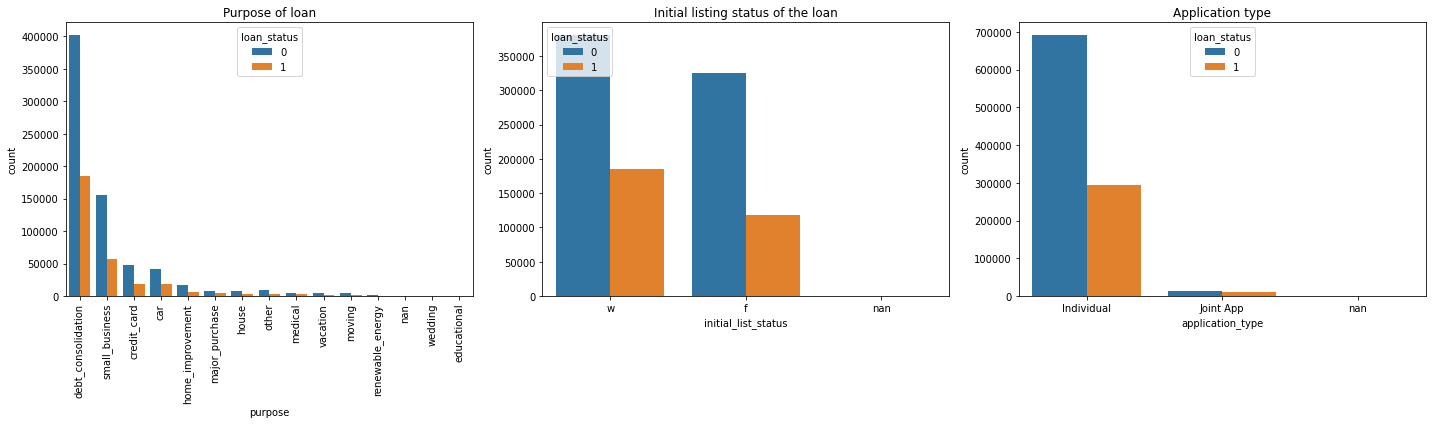

In [98]:
fig, ax = plt.subplots(1,3, figsize= (20,6))
create_countplot(ax[0],'purpose', df["purpose"],"Purpose of loan" ,"y")
create_countplot(ax[1],'initial_list_status', df["initial_list_status"],"Initial listing status of the loan" )
create_countplot(ax[2],'application_type', df["application_type"],"Application type" )
plt.tight_layout()
plt.show()



1.   Joint applicants tend to default more than individual applicants.

Joint applicant has a 43% chance of defaulting a loan whereas it is 30% for individual applicants.

2.    Maximum loans issued are for debt consolidation and credit card.



Text(0, 0.5, 'Defaulters rate')

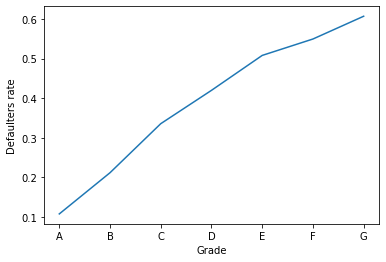

In [99]:
plt.plot(df.groupby('grade')['loan_status'].mean())
plt.xlabel("Grade")
plt.ylabel("Defaulters rate")

As the grade increases, the defaulters Rate also increases. 

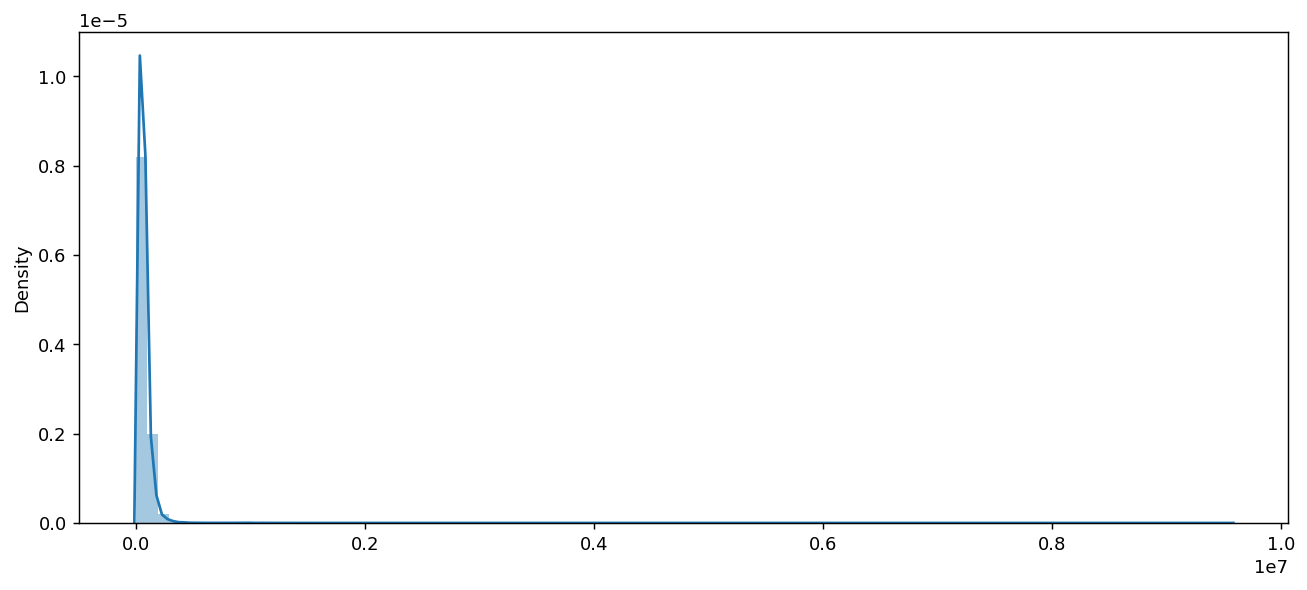

In [100]:
plt.figure(figsize=(12,5), dpi=130)
sns.distplot(x=df['annual_inc'], bins=100)

In [101]:
percent_of_rows_of_customers_with_annual_inc_more_than_250000 = len(df[df['annual_inc'] > 250000])*100/len(df) 
percent_of_rows_of_customers_with_annual_inc_more_than_250000

0.9535837267742541

In [102]:
df = df[df['annual_inc'] <= 250000]

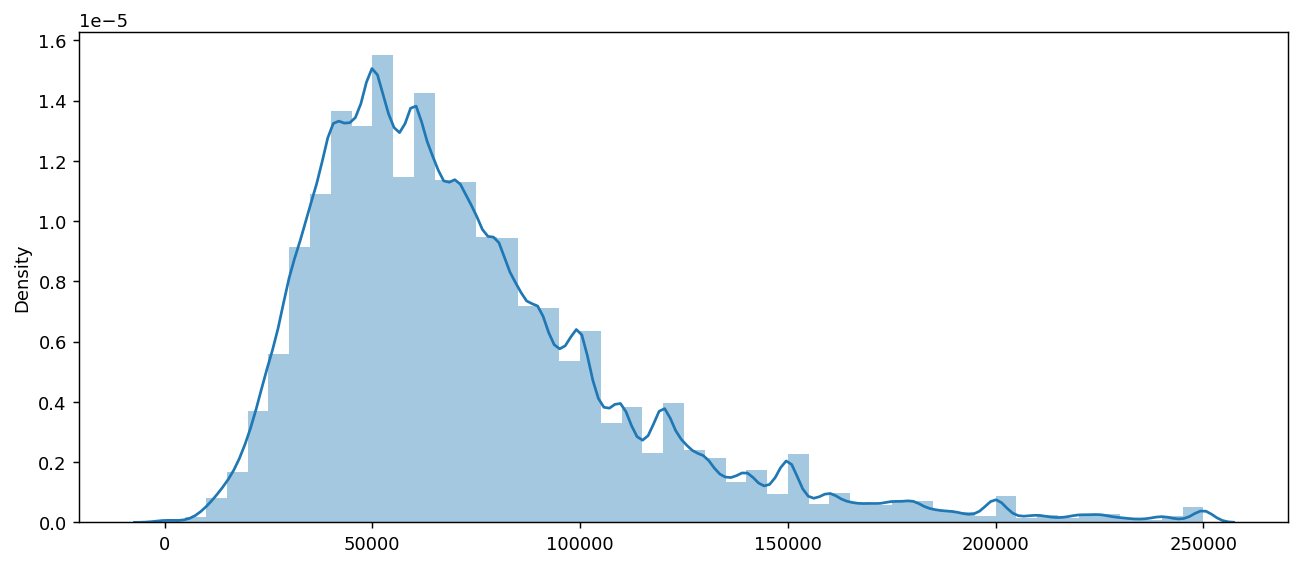

In [103]:
plt.figure(figsize=(12,5), dpi=130)
sns.distplot(x=df['annual_inc']);

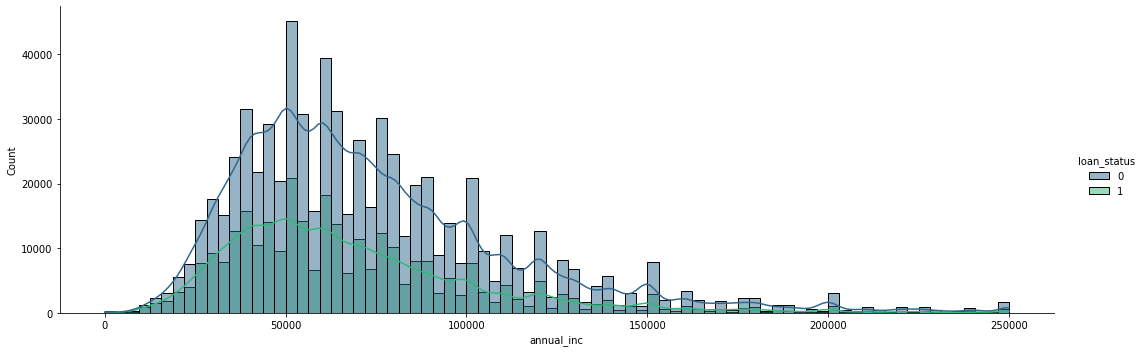

In [104]:
sns.displot(data=df, x='annual_inc', hue='loan_status', bins=80, height=5, aspect=3, kde=True, palette='viridis');

In [105]:
df.groupby('loan_status')['annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,696902.0,73864.088890,38765.897931,0.0,47000.0,65000.0,90387.75,250000.0
1,301436.0,68717.120098,36677.025710,0.0,43500.0,60000.0,85000.00,250000.0


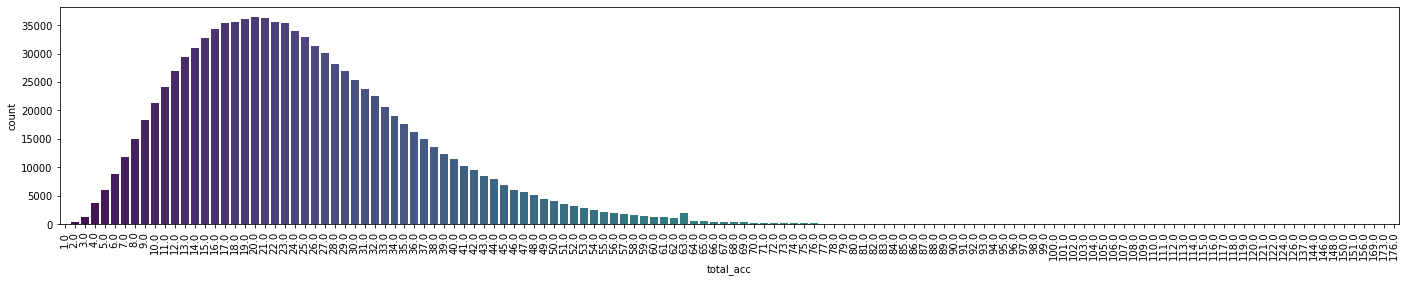

In [106]:
plt.figure(figsize=(24,4))
plt.xticks(rotation=90)
sns.countplot(data=df, x='total_acc', palette='viridis');

In [107]:
df = df[df['total_acc'] < 64]

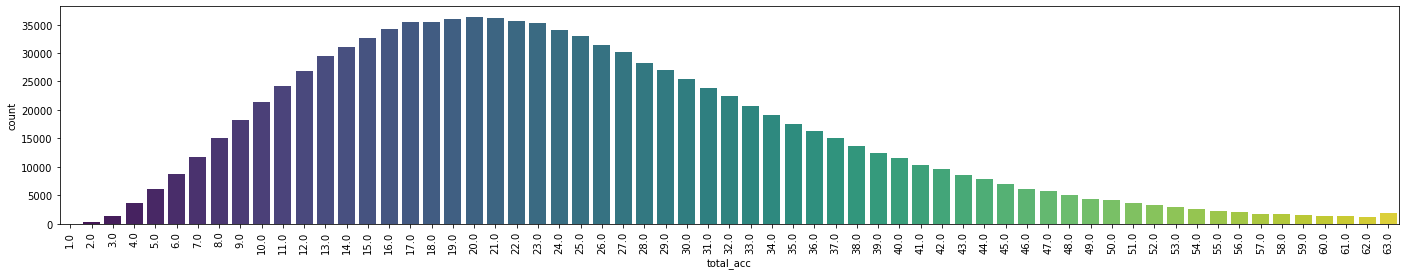

In [108]:
plt.figure(figsize=(24,4))
plt.xticks(rotation=90)
sns.countplot(data=df, x='total_acc', palette='viridis');

Text(0, 0.5, 'Defaulters rate')

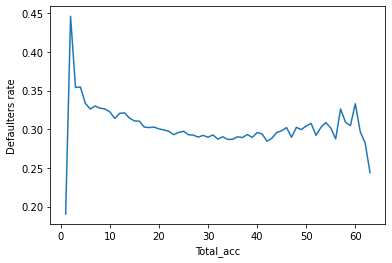

In [109]:
plt.plot(df.groupby('total_acc')['loan_status'].mean())
plt.xlabel("Total_acc")
plt.ylabel("Defaulters rate")

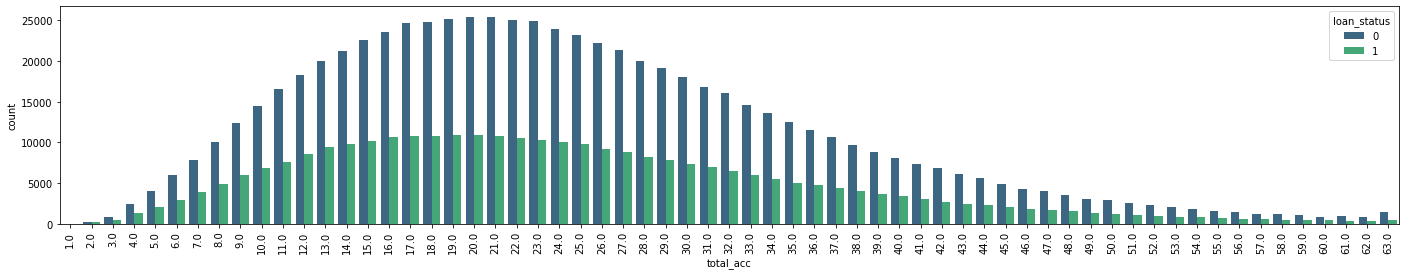

In [110]:
plt.figure(figsize=(24,4))
plt.xticks(rotation=90)
sns.countplot(data=df, x='total_acc', hue='loan_status', palette='viridis');

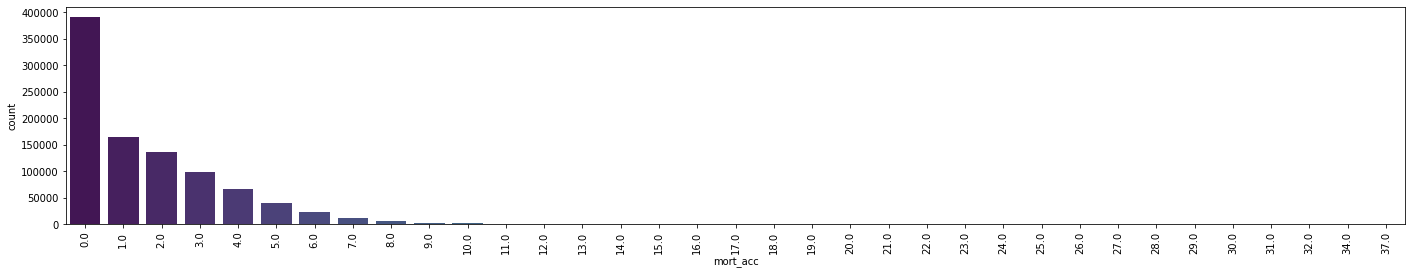

In [111]:
plt.figure(figsize=(24,4))
plt.xticks(rotation=90)
sns.countplot(data=df, x='mort_acc', palette='viridis');

In [112]:
df = df[df['mort_acc'] < 11]

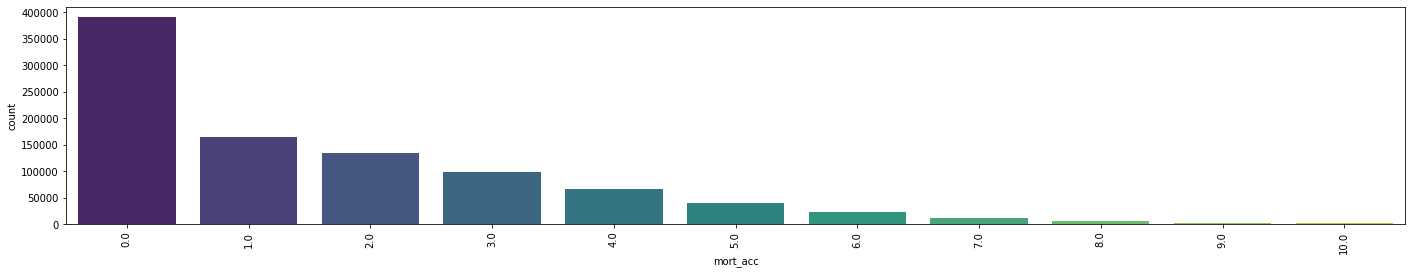

In [113]:
plt.figure(figsize=(24,4))
plt.xticks(rotation=90)
sns.countplot(data=df, x='mort_acc', palette='viridis');

Text(0, 0.5, 'Defaulters rate')

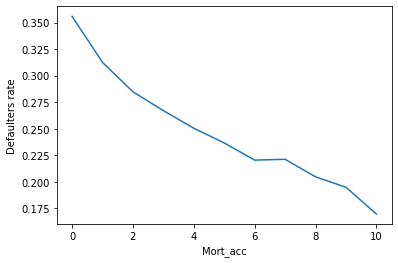

In [114]:
plt.plot(df.groupby('mort_acc')['loan_status'].mean())
plt.xlabel("Mort_acc")
plt.ylabel("Defaulters rate")

The more the Mortgage account, the less is the Defaulters Rate.

In [115]:
df = df.drop(['title','emp_title'],axis =1)

In [116]:
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda date: int(date[-4:]))

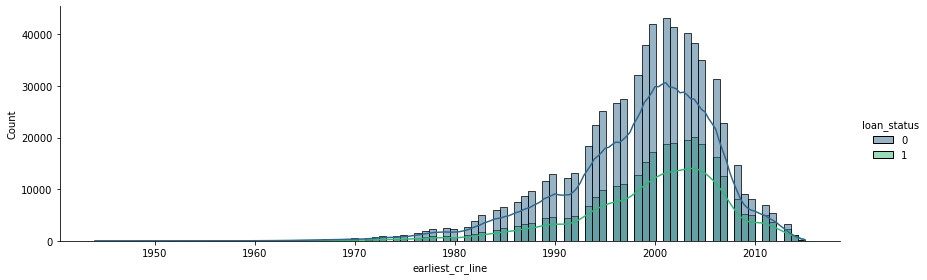

In [117]:
sns.displot(data=df, x='earliest_cr_line', hue='loan_status', bins=100, height=4, aspect=3, kde=True, palette='viridis');

Text(0, 0.5, 'Defaulters rate')

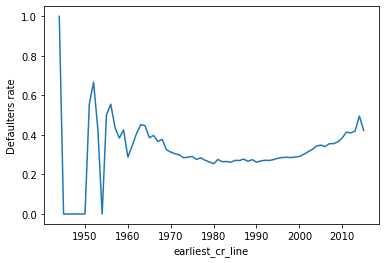

In [118]:
plt.plot(df.groupby('earliest_cr_line')['loan_status'].mean())
plt.xlabel("earliest_cr_line")
plt.ylabel("Defaulters rate")

In [119]:
df.groupby('loan_status')['earliest_cr_line'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,649809.0,1998.612552,7.575486,1945.0,1995.0,2000.0,2004.0,2015.0
1,291466.0,1999.651081,7.642252,1944.0,1996.0,2001.0,2005.0,2015.0


In [120]:
df['revol_util'] = np.where(df['revol_util'].isnull(),df['revol_util'].median(),df['revol_util'])


In [121]:
df['emp_length'] = np.where(df['emp_length'].isna(),0.0,df['emp_length'])

In [122]:
fig = px.bar(df['emp_length'].value_counts().sort_index()/len(df))
fig.show()

In [123]:
fig = px.line(df.groupby('emp_length')['loan_status'].mean())
fig.show()

As employment length increases, the Defaulters rate decreases.


In [124]:
df['fico'] = (df['fico_range_high'] + df['fico_range_low'])/2
df = df.drop(['fico_range_high','fico_range_low'],axis = 1)

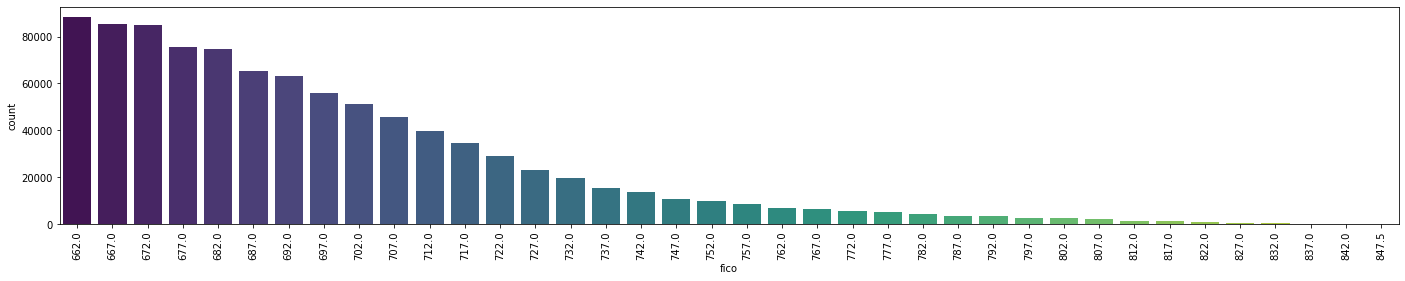

In [125]:
plt.figure(figsize=(24,4))
plt.xticks(rotation=90)
sns.countplot(data=df, x='fico', palette='viridis');

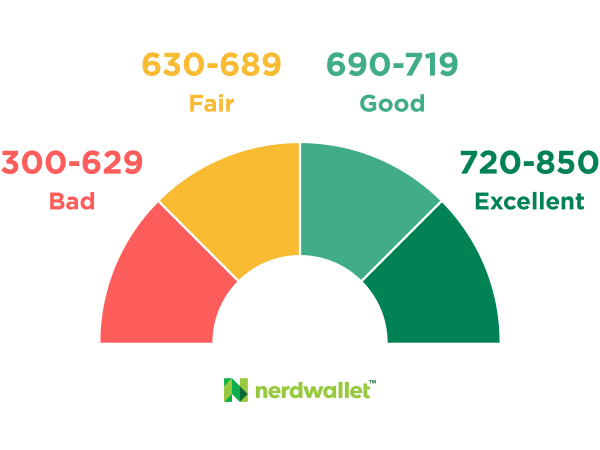

Text(0, 0.5, 'Defaulters Rate')

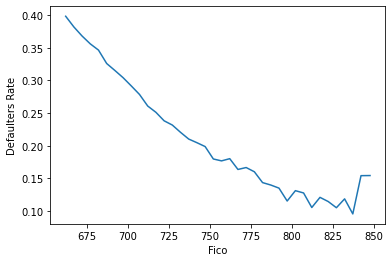

In [126]:
plt.plot(df.groupby('fico')['loan_status'].mean())
plt.xlabel("Fico")
plt.ylabel("Defaulters Rate")

As the FICO score increases, the Defaulters Rate decreases. 

Text(0, 0.5, 'Fico')

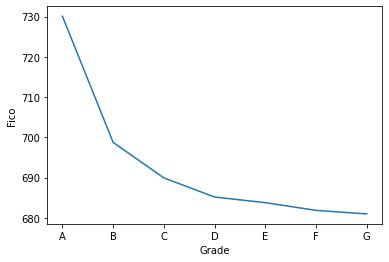

In [127]:
plt.plot(df.groupby('grade')['fico'].mean())
plt.xlabel("Grade")
plt.ylabel("Fico")

As the Fico Score decrease, the Grades increase.

In [128]:
df = df.dropna().reset_index()

In [129]:
df_copy = df.copy()

In [130]:
target_col = pd.DataFrame(df['loan_status'])

In [131]:
df = df.drop(['index','loan_status'],axis =1)

In [132]:
num_col = df.select_dtypes(exclude = 'object')

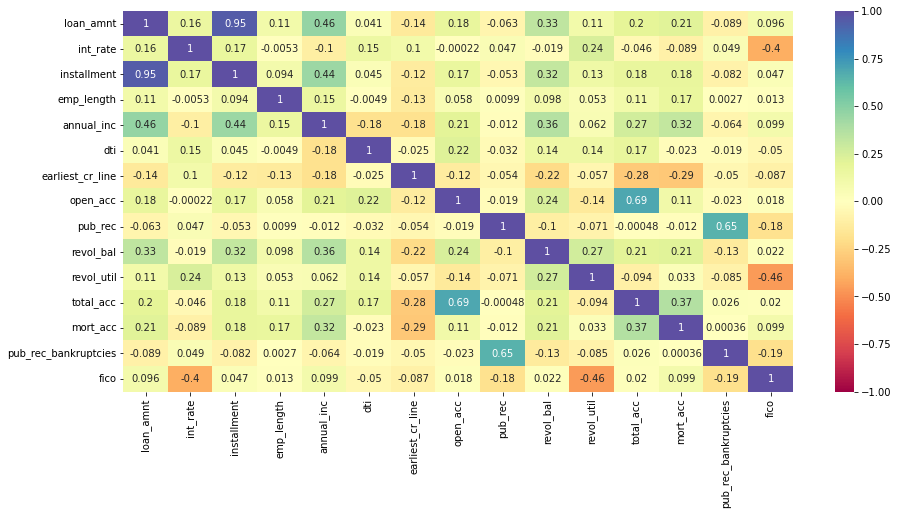

In [133]:
plt.figure(figsize= (15,7))
sns.heatmap(num_col.corr(), vmin=1, vmax=-1, annot=True, cmap="Spectral")

In [134]:
num_col = num_col.drop(['pub_rec_bankruptcies','open_acc','installment'],axis = 1)

Variance Inflation Factor: 
    
It is a measure of the amount of multicollinearity in a set of multiple regression variables.

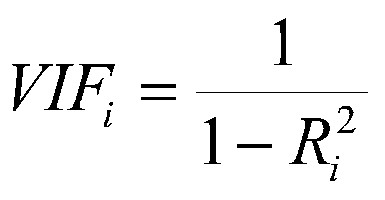

                                            
VIF > 10 means Serious Multicollinearity is present. So, we have 			removed variables having VIF >10.  

In [135]:
vif_data2 = pd.DataFrame()
vif_data2["feature"] = num_col.columns
vif_data2["VIF"] = [variance_inflation_factor(num_col.values, i)
                          for i in range(len(num_col.columns))]
vif_data2

,feature,VIF
0,loan_amnt,5.573340
1,int_rate,12.000234
2,emp_length,3.277594
3,annual_inc,7.477821
4,dti,4.428331
5,earliest_cr_line,935.114577
6,pub_rec,1.208234
7,revol_bal,2.322156
8,revol_util,8.547927
9,total_acc,7.614297


In [136]:
num_col = num_col.drop(['int_rate','earliest_cr_line'],axis =1)

In [138]:
vif_data = pd.DataFrame()
vif_data["feature"] = num_col.columns
vif_data["VIF"] = [variance_inflation_factor(num_col.values, i)
                          for i in range(len(num_col.columns))]
vif_data

,feature,VIF
0,loan_amnt,5.151008
1,emp_length,3.276604
2,annual_inc,7.366892
3,dti,4.379698
4,pub_rec,1.139843
5,revol_bal,2.272354
6,revol_util,5.839211
7,total_acc,7.383874
8,mort_acc,2.148590
9,fico,15.054335


In [137]:
num_col.head()

,loan_amnt,emp_length,annual_inc,dti,pub_rec,revol_bal,revol_util,total_acc,mort_acc,fico
0,18000.0,7.0,150000.0,9.39,1.0,14052.0,40.7,27.0,2.0,667.0
1,4225.0,5.0,35000.0,15.22,0.0,1058.0,24.6,6.0,0.0,727.0
2,16000.0,10.0,65000.0,18.96,1.0,5157.0,54.3,20.0,0.0,677.0
3,24250.0,4.0,75000.0,20.84,0.0,24799.0,65.3,21.0,2.0,662.0
4,10000.0,2.0,55000.0,35.70,0.0,38623.0,78.0,28.0,6.0,687.0


In [68]:
cat_col = df.select_dtypes(include = 'object')

Chisquare Test for Independence

    • Crammer’s V and Phi:
 It is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). It is based on Pearson's chi-squared statistic and was published by Harald Cramer in 1946.

 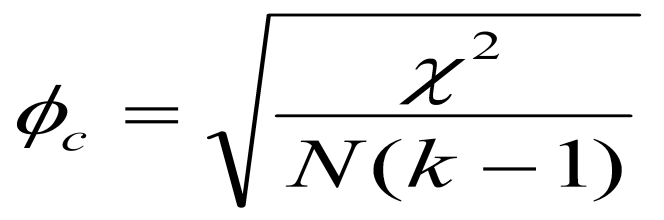

 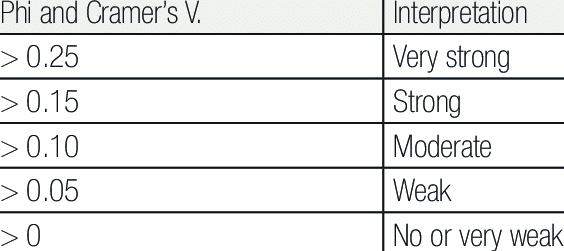

In [ ]:
# rp.summary_cat(cat_col)

In [ ]:
# crosstab, test_results, expected = rp.crosstab(data['home_ownership'], data['grade'],
#                                                test= "chi-square",
#                                                expected_freqs= True,
#                                                prop= "cell")
# test_results

Perform the above code for each categorical variable wrt to other catetgorical variable.

In [70]:
cat_col = cat_col.drop(['sub_grade','issue_d','grade'],axis =1)

In [71]:
cat_col.describe().T

,count,unique,top,freq
term,940981,2,36 months,692992
home_ownership,940981,6,MORTGAGE,460105
verification_status,940981,3,Source Verified,355372
purpose,940981,13,debt_consolidation,554004
addr_state,940981,51,CA,136948
initial_list_status,940981,2,w,554009
application_type,940981,2,Individual,917835


In [ ]:
enc = LabelEncoder()
Cat_col = cat_col.apply(LabelEncoder().fit_transform)

In [ ]:
feature_col = pd.concat([num_col,Cat_col],axis =1)

In [ ]:
feature_col.columns

Index(['loan_amnt', 'emp_length', 'annual_inc', 'dti', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'mort_acc', 'fico', 'term', 'home_ownership',
       'verification_status', 'purpose', 'addr_state', 'initial_list_status',
       'application_type'],
      dtype='object')

# **Train test Split**

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1 , test_size = 0.2 , random_state=42)
for train_index, test_index in sss.split(feature_col, target_col):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = feature_col.iloc[train_index], feature_col.iloc[test_index]
  y_train, y_test = target_col.iloc[train_index], target_col.iloc[test_index]


TRAIN: [425965 345793 905771 ... 803017 207843 523517] TEST: [203678 646876 230273 ... 163379 624920 939557]


In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)  


# **Creating Functions for modelling and Evaluation**

In [ ]:
def fit_score_clf(clf,X_train,y_train,X_test,y_test, name = 'clf'):

  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
  clf_report['clf'] = name
    
  return clf_report

In [ ]:
def Confusion_matrix(clf):
  y_pred = clf.predict(X_test)
  plot_confusion_matrix(clf, X_test , y_test , normalize='true', cmap = 'Blues')


In [ ]:
def rocscore(clf,X_train,y_train,X_test,y_test, name = 'clf'):

  clf.fit(X_train, y_train)
  ytrain_pred = clf.predict_proba(X_train)
  print('Training roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
  ytest_pred = clf.predict_proba(X_test)
  print('Test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))




In [ ]:
roc_dict = {}   # ROC dict for FPR and TPR  (FPR = False Positive Rate  & TPR = True Positive Rate)

def modify_roc_dict(clf, y_test, X_test, name ,dict_modify):                                         # clf = Classifier
  fpr, tpr, thresholds = roc_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
  ROC_AUC_SCORE = roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])
  clf_roc_dict = {'fpr':fpr, 'tpr': tpr, 'thresholds': thresholds ,'ROC_AUC_SCORE': ROC_AUC_SCORE}
    
  dict_modify[name] = clf_roc_dict

# **WITHOUT OVERSAMPLING**



# **LOGISTIC REGRESSION**

Logistic Regression without hyperparameter tunning


In [ ]:
lr = LogisticRegression(penalty='l1',
                        C = 1.0,
                        solver = 'liblinear',
                        max_iter = 1000,
                        n_jobs = 2)

lr_report = fit_score_clf(lr,X_train,y_train,X_test,y_test, name = 'lr')
lr_report

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.726774,0.586634,0.710495,0.656704,0.683382,lr
recall,0.930444,0.220089,0.710495,0.575267,0.710495,lr
f1-score,0.816094,0.320089,0.710495,0.568091,0.662514,lr
support,129925.000000,58272.000000,0.710495,188197.000000,188197.000000,lr


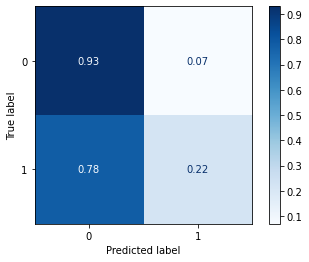

In [ ]:
Confusion_matrix(lr)

In [ ]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.650990
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:               752784
Model:                          Logit   Df Residuals:                   752767
Method:                           MLE   Df Model:                           16
Date:                Mon, 16 May 2022   Pseudo R-squ.:                -0.05201
Time:                        10:50:45   Log-Likelihood:            -4.9005e+05
converged:                       True   LL-Null:                   -4.6583e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1614      0.003     50.715      0.000       0.155       0.168
x2            -0.0587      0.

In [ ]:
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ["Lower CI", "Upper CI", "OR"]
np.exp(conf)

,Lower CI,Upper CI,OR
x1,1.167872,1.182534,1.175180
x2,0.938375,0.947540,0.942947
x3,0.931266,0.942944,0.937087
x4,1.300090,1.319004,1.309513
x5,1.011928,1.022050,1.016977
x6,0.953042,0.964105,0.958557
x7,0.921926,0.932945,0.927419
x8,0.931650,0.942231,0.936926
x9,0.893017,0.903776,0.898381
x10,0.735538,0.744243,0.739878


In [ ]:
print(lr.coef_,np.exp(lr.coef_))

[[ 0.2038491  -0.06975218 -0.09570042  0.29017373  0.01695204 -0.04970743
  -0.08367809 -0.07137287 -0.1402425  -0.39619812  0.37760055  0.11949782
   0.08217916  0.11355784  0.00349213  0.08320334  0.01410306]] [[1.22611312 0.93262492 0.90873622 1.33665969 1.01709654 0.95150777
  0.91972728 0.93111464 0.86914745 0.67287337 1.45878012 1.12693079
  1.0856503  1.12025668 1.00349823 1.08676277 1.01420297]]


In [ ]:
A = pd.DataFrame(lr.coef_).T

In [ ]:
importance_df = pd.DataFrame({
    'feature': feature_col.columns,
    'importance': abs(A[0])
}).sort_values('importance', ascending=False)

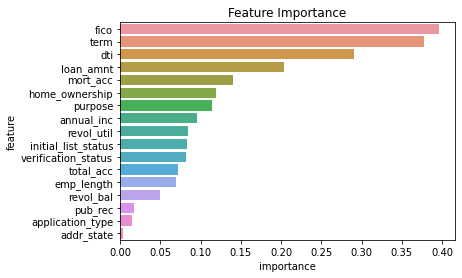

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(25), x='importance', y='feature');

**LOGISTIC REGRESSION WITH HYPERPARAMETER TUNNING**

In [ ]:
lr1 = LogisticRegression(penalty='l1',
                        C = 1.0,
                        solver = 'liblinear',
                        max_iter = 1000,
                        n_jobs = 2,
                        class_weight = 'balanced')

lr1_report = fit_score_clf(lr1,X_train,y_train,X_test,y_test, name = 'lr1')
lr1_report

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.794594,0.441277,0.638469,0.617935,0.685195,lr1
recall,0.642378,0.629754,0.638469,0.636066,0.638469,lr1
f1-score,0.710424,0.518931,0.638469,0.614678,0.651132,lr1
support,129925.000000,58272.000000,0.638469,188197.000000,188197.000000,lr1


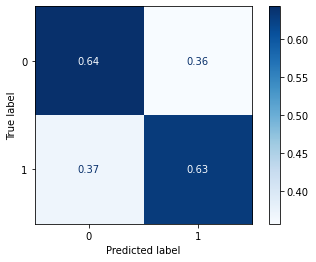

In [ ]:
Confusion_matrix(lr1)

In [ ]:
A = pd.DataFrame(lr1.coef_).T

In [ ]:
importance_df = pd.DataFrame({
    'feature': feature_col.columns,
    'importance': abs(A[0])
}).sort_values('importance', ascending=False)

In [ ]:
importance_df['cumpercentage'] = importance_df['importance'].cumsum()/importance_df['importance'].sum()*100

In [ ]:
importance_df

,feature,importance,cumpercentage
9,fico,0.399492,17.713213
10,term,0.378091,34.477521
3,dti,0.313011,48.356246
0,loan_amnt,0.202194,57.321410
8,mort_acc,0.136538,63.375407
11,home_ownership,0.119234,68.662153
13,purpose,0.117250,73.860926
2,annual_inc,0.089917,77.847793
6,revol_util,0.088833,81.786574
12,verification_status,0.085520,85.578482


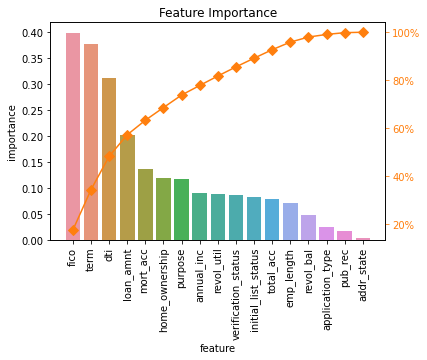

In [ ]:
fig, ax1 = plt.subplots()
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(25), y='importance', x='feature');
ax1.set_xticklabels(importance_df['feature'], rotation=90)
ax2 = ax1.twinx()
ax2.plot(importance_df['feature'], importance_df['cumpercentage'], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.tick_params(axis="y", colors="C1")
plt.show()


In [ ]:
modify_roc_dict(clf = lr1 ,
                y_test = y_test,
                X_test = X_test,
                name = 'Logistic_Reg(hyp_parameter_tuned)(area = 0.6916)',
                dict_modify = roc_dict)

# **RANDOM FOREST**

RANDOM FOREST WITHOUT HYPERPARAMETER TUNNING


In [ ]:
RF = RandomForestClassifier(n_estimators=100,
                            criterion= 'gini',
                            n_jobs=-1, 
                            random_state = 42)
                            
lin_RF_report = fit_score_clf(RF,X_train,y_train,X_test,y_test, name = 'Random_Forest')
lin_RF_report


,0,1,accuracy,macro avg,weighted avg,clf
precision,0.731879,0.582328,0.712121,0.657103,0.685573,Random_Forest
recall,0.920069,0.248473,0.712121,0.584271,0.712121,Random_Forest
f1-score,0.815255,0.348321,0.712121,0.581788,0.670677,Random_Forest
support,129925.000000,58272.000000,0.712121,188197.000000,188197.000000,Random_Forest


In [ ]:
importance_df = pd.DataFrame({
    'feature': feature_col.columns,
    'importance': RF.feature_importances_
}).sort_values('importance', ascending=False)

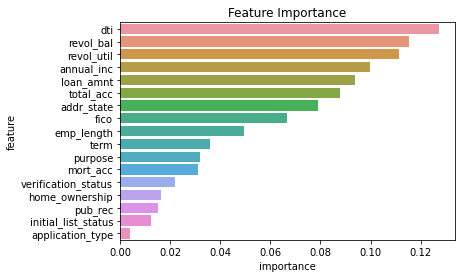

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(21), x='importance', y='feature');

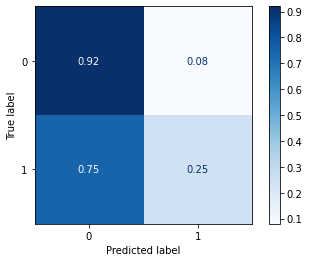

In [ ]:
Confusion_matrix(RF)

RANDOM FOREST WITH HYPERPARAMETER TUNNING

In [ ]:
RF1 = RandomForestClassifier(n_estimators=100,
                            criterion= 'gini',
                            n_jobs=-1, 
                            random_state = 42,
                            max_depth = 15,
                            class_weight = 'balanced')
                            
lin_RF1_report = fit_score_clf(RF1,X_train,y_train,X_test,y_test, name = 'Random_Forest')
lin_RF1_report


,0,1,accuracy,macro avg,weighted avg,clf
precision,0.791313,0.464759,0.662582,0.628036,0.690201,Random_Forest
recall,0.694370,0.591708,0.662582,0.643039,0.662582,Random_Forest
f1-score,0.739679,0.520606,0.662582,0.630142,0.671846,Random_Forest
support,129925.000000,58272.000000,0.662582,188197.000000,188197.000000,Random_Forest


In [ ]:
importance_df = pd.DataFrame({
    'feature': feature_col.columns,
    'importance': RF1.feature_importances_
}).sort_values('importance', ascending=False)

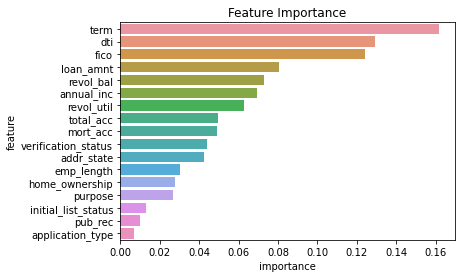

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(21), x='importance', y='feature');

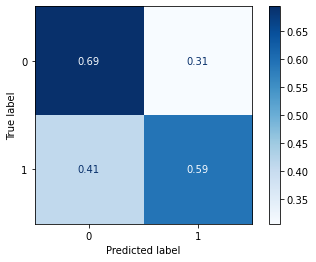

In [ ]:
Confusion_matrix(RF1)

In [ ]:
modify_roc_dict(clf = RF1 ,
                y_test = y_test,
                X_test = X_test,
                name = 'Random Forest',
                dict_modify = roc_dict)

# **XGB**

XGB WITHOUT HYPERPARAMETER TUNNING

In [ ]:
xgb = xgb.XGBClassifier(n_estimators=300,
                        learning_rate = 0.1,
                            subsample=0.9,
                            n_jobs=-1)

xgb_report = fit_score_clf(xgb, X_train, y_train, X_test,y_test, name='xgb')
xgb_report

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.734017,0.600733,0.716637,0.667375,0.692748,xgb
recall,0.924587,0.252986,0.716637,0.588787,0.716637,xgb
f1-score,0.818354,0.356035,0.716637,0.587195,0.675205,xgb
support,129925.000000,58272.000000,0.716637,188197.000000,188197.000000,xgb


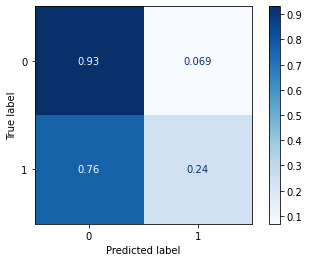

In [ ]:
Confusion_matrix(xgb)

In [ ]:
importance_df = pd.DataFrame({
    'feature': feature_col.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

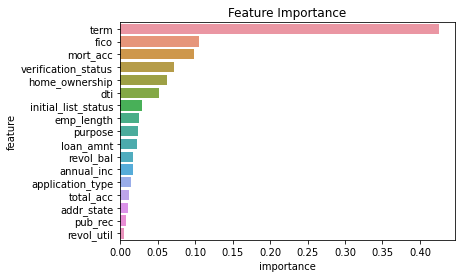

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(21), x='importance', y='feature');

XGB WITH HYPERPARAMETER TUNNING

In [ ]:
xgb1 = xgb.XGBClassifier(n_estimators=300,
                        learning_rate = 1,
                            subsample=0.9,
                            n_jobs=-1,
                        max_depth = 12)

xgb1_report = fit_score_clf(xgb1, X_train, y_train, X_test,y_test, name='xgb')
xgb1_report

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.732805,0.433986,0.656775,0.583395,0.640281,xgb
recall,0.791395,0.356621,0.656775,0.574008,0.656775,xgb
f1-score,0.760974,0.391518,0.656775,0.576246,0.646578,xgb
support,129925.000000,58272.000000,0.656775,188197.000000,188197.000000,xgb


In [ ]:
importance_df = pd.DataFrame({
    'feature': feature_col.columns,
    'importance': xgb1.feature_importances_
}).sort_values('importance', ascending=False)

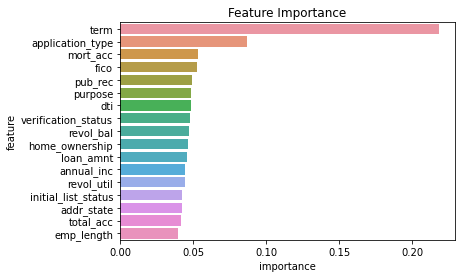

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(21), x='importance', y='feature');

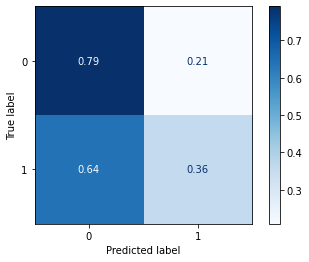

In [ ]:
y_pred = xgb1.predict(X_test)
plot_confusion_matrix(xgb1, X_test , y_test , normalize='true', cmap = 'Blues')


In [ ]:
modify_roc_dict(clf = xgb1 ,
                y_test = y_test,
                X_test = X_test,
                name = 'XGB',
                dict_modify = roc_dict)

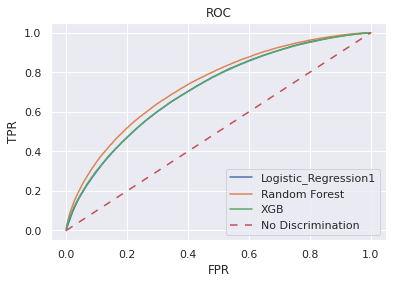

In [ ]:
for key in roc_dict:
    clf = roc_dict[key]
    plt.plot(clf['fpr'], clf['tpr'], label=key)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.legend()
plt.show()

# **WITH OVERSAMPLING**

In [ ]:
df1 = df_copy[df_copy['loan_status'] == 1]

In [ ]:
DF = pd.concat([df_copy,df1],axis = 0)

In [ ]:
DF = DF.dropna().reset_index()

In [ ]:
Target_col = pd.DataFrame(DF['loan_status'])

In [ ]:
DF = DF.drop(['index','loan_status','level_0'],axis =1)

In [ ]:
Num_col = DF.select_dtypes(exclude = 'object')

In [ ]:
Num_col = Num_col.drop(['pub_rec_bankruptcies','open_acc','installment','int_rate','earliest_cr_line'],axis =1)

In [ ]:
CAT_col = DF.select_dtypes(include = 'object')

In [ ]:
CAT_col = CAT_col.drop(['sub_grade','issue_d','grade'],axis =1)

In [ ]:
enc = LabelEncoder()
CAT_COL = CAT_col.apply(LabelEncoder().fit_transform)

In [ ]:
Feature_col = pd.concat([Num_col,CAT_COL],axis = 1)

In [ ]:
Target_col.to_csv('Target_col.csv')

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1 , test_size = 0.2 , random_state=42)
for train_index, test_index in sss.split(Feature_col, Target_col):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train1, X_test1 = Feature_col.iloc[train_index], Feature_col.iloc[test_index]
  y_train1, y_test1 = Target_col.iloc[train_index], Target_col.iloc[test_index]


TRAIN: [ 923522  120806  844409 ...  440421 1009402  236286] TEST: [320557 374792 723167 ... 242876 442627 260522]


In [ ]:
ss = StandardScaler()
X_train1 = ss.fit_transform(X_train1)
X_test1 = ss.fit_transform(X_test1)  


In [ ]:
def Confusion_matrix(clf):
  y_pred = clf.predict(X_test1)
  plot_confusion_matrix(clf, X_test1 , y_test1 , normalize='true', cmap = 'Blues')


In [ ]:
roc_dict1 = {}   # ROC dict for FPR and TPR  (FPR = False Positive Rate  & TPR = True Positive Rate)

def modify_roc_dict(clf, y_test, X_test, name ,dict_modify):                                         # clf = Classifier
  fpr, tpr, thresholds = roc_curve(y_test1,
                                     clf.predict_proba(X_test1)[:,1],
                                     pos_label=1)
  ROC_AUC_SCORE = roc_auc_score(y_test,clf.predict_proba(X_test1)[:,1])
  clf_roc_dict = {'fpr':fpr, 'tpr': tpr, 'thresholds': thresholds ,'ROC_AUC_SCORE': ROC_AUC_SCORE}
    
  dict_modify[name] = clf_roc_dict

# **LOGISTIC REGRESSION OVERSAMPLING**

In [ ]:
lr2 = LogisticRegression(penalty='l1',
                        C = 1.0,
                        solver = 'liblinear',
                        max_iter = 1000,
                        n_jobs = 2)

lr2_report = fit_score_clf(lr2,X_train1,y_train1,X_test1,y_test1, name = 'lr2')
lr2_report

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.643989,0.630223,0.638123,0.637106,0.637480,lr2
recall,0.701104,0.567911,0.638123,0.634508,0.638123,lr2
f1-score,0.671334,0.597446,0.638123,0.634390,0.636396,lr2
support,129925.000000,116543.000000,0.638123,246468.000000,246468.000000,lr2


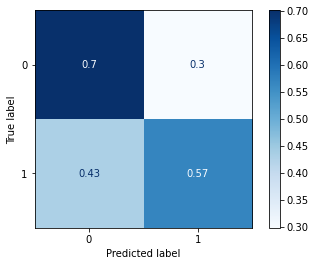

In [ ]:
Confusion_matrix(lr2)

In [ ]:
A = pd.DataFrame(lr2.coef_).T

In [ ]:
importance_df = pd.DataFrame({
    'feature': Feature_col.columns,
    'importance': abs(A[0])
}).sort_values('importance', ascending=False)

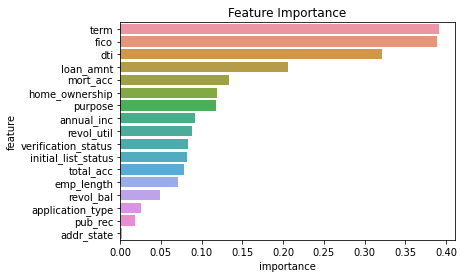

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(25), x='importance', y='feature');

In [ ]:
modify_roc_dict(clf = lr2 ,
                y_test = y_test1,
                X_test = X_test1,
                name = 'Logistic_Regression2',
                dict_modify = roc_dict1)

# **RANDOM FOREST OVERSAMPLING**

In [ ]:
RF2 = RandomForestClassifier(n_estimators=100,
                            criterion= 'gini',
                            n_jobs=-1, 
                            random_state = 42)
                            
lin_RF2_report = fit_score_clf(RF2,X_train1,y_train1,X_test1,y_test1, name = 'Random_Forest2')
lin_RF2_report


,0,1,accuracy,macro avg,weighted avg,clf
precision,0.886306,0.815629,0.850143,0.850968,0.852886,Random_Forest2
recall,0.821043,0.882584,0.850143,0.851814,0.850143,Random_Forest2
f1-score,0.852427,0.847787,0.850143,0.850107,0.850233,Random_Forest2
support,129925.000000,116543.000000,0.850143,246468.000000,246468.000000,Random_Forest2


In [ ]:
roc_auc_score(y_test1,RF2.predict_proba(X_test1)[:,1])

0.9266907462992164

In [ ]:
importance_df = pd.DataFrame({
    'feature': Feature_col.columns,
    'importance': RF2.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df['cumpercentage'] = importance_df['importance'].cumsum()/importance_df['importance'].sum()*100

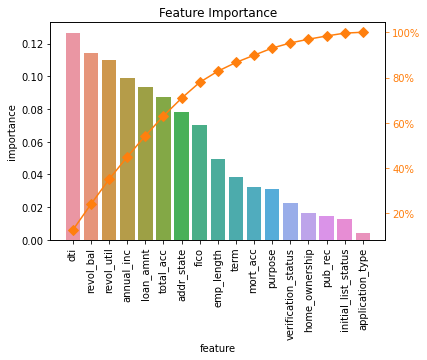

In [ ]:
fig, ax1 = plt.subplots()
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(25), y='importance', x='feature');
ax1.set_xticklabels(importance_df['feature'], rotation=90)
ax2 = ax1.twinx()
ax2.plot(importance_df['feature'], importance_df['cumpercentage'], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.tick_params(axis="y", colors="C1")
plt.show()


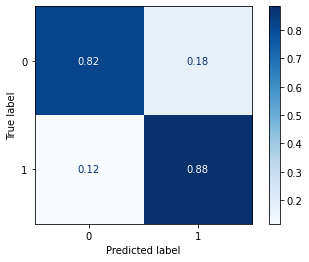

In [ ]:
Confusion_matrix(RF2)

In [ ]:
modify_roc_dict(clf = RF2,
                y_test = y_test1,
                X_test = X_test1,
                name = 'Random Forest(oversampling)(area = 0.93)',
                dict_modify = roc_dict)

# **XBG OVERSAMPLING**

In [ ]:
xgb2 = xgb.XGBClassifier(n_estimators=300,
                            subsample=0.9,
                            n_jobs=-1)
xgb2.fit(X_train1,y_train1)
y_pred = xgb2.predict(X_test1)
xgb2_report = pd.DataFrame(classification_report(y_test1, y_pred, output_dict=True))


In [ ]:
xgb2_report

,0,1,accuracy,macro avg,weighted avg
precision,0.658012,0.641564,0.650827,0.649788,0.650234
recall,0.702975,0.592691,0.650827,0.647833,0.650827
f1-score,0.679751,0.616160,0.650827,0.647955,0.649682
support,129925.000000,116543.000000,0.650827,246468.000000,246468.000000


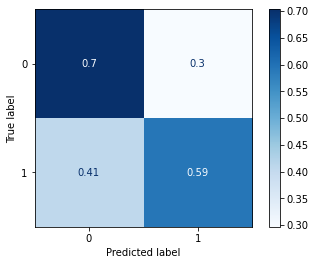

In [ ]:
y_pred = xgb2.predict(X_test1)
plot_confusion_matrix(xgb2, X_test1 , y_test1 , normalize='true', cmap = 'Blues')


In [ ]:
importance_df = pd.DataFrame({
    'feature': Feature_col.columns,
    'importance': xgb2.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df['cumpercentage'] = importance_df['importance'].cumsum()/importance_df['importance'].sum()*100

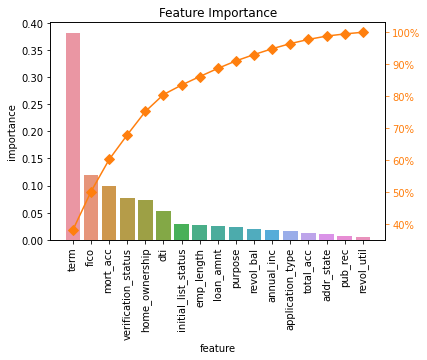

In [ ]:
fig, ax1 = plt.subplots()
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(25), y='importance', x='feature');
ax1.set_xticklabels(importance_df['feature'], rotation=90)
ax2 = ax1.twinx()
ax2.plot(importance_df['feature'], importance_df['cumpercentage'], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.tick_params(axis="y", colors="C1")
plt.show()

In [ ]:
modify_roc_dict(clf = xgb2 ,
                y_test = y_test1,
                X_test = X_test1,
                name = 'XGB(oversampling)(area = 0.71)',
                dict_modify = roc_dict)

# SUMMARY OF LR , RF , XGB 

In [ ]:
datalr =  {'Evaluation_metrics -->':['Training_accuracy', 'Testing_accuracy', 'Precision','Specificity','Recall(Sensitivity)','f1-Score','ROC-AUC_Score'],
        'logistic':[accuracy_score(y_train,lr.predict(X_train)),accuracy_score(y_test,lr.predict(X_test)), precision_score(y_test,lr.predict(X_test)), recall_score(y_test,lr.predict(X_test),pos_label=0),recall_score(y_test,lr.predict(X_test)),f1_score(y_test,lr.predict(X_test)),roc_auc_score(y_test,lr.predict_proba(X_test)[:,1])],
        'logistic(Hyperparameter tunned)':[accuracy_score(y_train,lr1.predict(X_train)),accuracy_score(y_test,lr1.predict(X_test)), precision_score(y_test,lr1.predict(X_test)),recall_score(y_test,lr1.predict(X_test),pos_label=0),recall_score(y_test,lr1.predict(X_test)),f1_score(y_test,lr1.predict(X_test)),roc_auc_score(y_test,lr1.predict_proba(X_test)[:,1])],
        'logistic(Oversampling)':[accuracy_score(y_train1,lr2.predict(X_train1)),accuracy_score(y_test1,lr2.predict(X_test1)), precision_score(y_test1,lr2.predict(X_test1)),recall_score(y_test1,lr2.predict(X_test1),pos_label=0) ,recall_score(y_test1,lr2.predict(X_test1)),f1_score(y_test1,lr2.predict(X_test1)),roc_auc_score(y_test1,lr2.predict_proba(X_test1)[:,1])]}

In [ ]:
summary1 = pd.DataFrame(datalr)

In [ ]:
summary1.T

,0,1,2,3,4,5,6
Evaluation_metrics -->,Training_accuracy,Testing_accuracy,Precision,Specificity,Recall(Sensitivity),f1-Score,ROC-AUC_Score
logistic,0.710217,0.710495,0.586634,0.930444,0.220089,0.320089,0.691379
logistic(Hyperparameter tunned),0.639652,0.638469,0.441278,0.642371,0.629771,0.518938,0.691628
logistic(Oversampling),0.638185,0.638123,0.630223,0.701104,0.567911,0.597446,0.690962


In [ ]:
datarf =  {'Evaluation_metrics -->':['Training_accuracy', 'Testing_accuracy', 'Precision','Specificity','Recall(Sensitivity)','f1-Score','ROC-AUC_Score'],
        'RandomForest':[accuracy_score(y_train,RF.predict(X_train)),accuracy_score(y_test,RF.predict(X_test)), precision_score(y_test,RF.predict(X_test)), recall_score(y_test,RF.predict(X_test),pos_label=0),recall_score(y_test,RF.predict(X_test)),f1_score(y_test,RF.predict(X_test)),roc_auc_score(y_test,RF.predict_proba(X_test)[:,1])],
        'RandomForest(Hyperparameter tunned)':[accuracy_score(y_train,RF1.predict(X_train)),accuracy_score(y_test,RF1.predict(X_test)), precision_score(y_test,RF1.predict(X_test)),recall_score(y_test,RF1.predict(X_test),pos_label=0),recall_score(y_test,RF1.predict(X_test)),f1_score(y_test,RF1.predict(X_test)),roc_auc_score(y_test,RF1.predict_proba(X_test)[:,1])],
        'RandomForest(Oversampling)':[accuracy_score(y_train1,RF2.predict(X_train1)),accuracy_score(y_test1,RF2.predict(X_test1)), precision_score(y_test1,RF2.predict(X_test1)),recall_score(y_test1,RF2.predict(X_test1),pos_label=0) ,recall_score(y_test1,RF2.predict(X_test1)),f1_score(y_test1,RF2.predict(X_test1)),roc_auc_score(y_test1,RF2.predict_proba(X_test1)[:,1])]}

In [ ]:
summary2 = pd.DataFrame(datarf)

In [ ]:
summary2.T

,0,1,2,3,4,5,6
Evaluation_metrics -->,Training_accuracy,Testing_accuracy,Precision,Specificity,Recall(Sensitivity),f1-Score,ROC-AUC_Score
RandomForest,0.999992,0.712121,0.582328,0.920069,0.248473,0.348321,0.695187
RandomForest(Hyperparameter tunned),0.731541,0.662582,0.464759,0.69437,0.591708,0.520606,0.703043
RandomForest(Oversampling),1.0,0.850143,0.815629,0.821043,0.882584,0.847787,0.926691


In [ ]:
dataxgb =  {'Evaluation_metrics -->':['Training_accuracy', 'Testing_accuracy', 'Precision','Specificity','Recall(Sensitivity)','f1-Score','ROC-AUC_Score'],
        'XGB':[accuracy_score(y_train,xgb.predict(X_train)),accuracy_score(y_test,xgb.predict(X_test)), precision_score(y_test,xgb.predict(X_test)),recall_score(y_test,xgb.predict(X_test),pos_label=0),recall_score(y_test,xgb.predict(X_test)),f1_score(y_test,xgb.predict(X_test)),roc_auc_score(y_test,xgb.predict_proba(X_test)[:,1])],
        'XGB(Hyperparameter tunned)':[accuracy_score(y_train,xgb1.predict(X_train)),accuracy_score(y_test,xgb1.predict(X_test)), precision_score(y_test,xgb1.predict(X_test)),recall_score(y_test,xgb1.predict(X_test),pos_label=0),recall_score(y_test,xgb1.predict(X_test)),f1_score(y_test,xgb1.predict(X_test)),roc_auc_score(y_test,xgb1.predict_proba(X_test)[:,1])],
        'XGB(Oversampling)':[accuracy_score(y_train1,xgb2.predict(X_train1)),accuracy_score(y_test1,xgb2.predict(X_test1)), precision_score(y_test1,xgb2.predict(X_test1)),recall_score(y_test1,xgb2.predict(X_test1),pos_label=0) ,recall_score(y_test1,xgb2.predict(X_test1)),f1_score(y_test1,xgb2.predict(X_test1)),roc_auc_score(y_test1,xgb2.predict_proba(X_test1)[:,1])]}

In [ ]:
summary3 = pd.DataFrame(dataxgb)

In [ ]:
summary3.T

,0,1,2,3,4,5,6
Evaluation_metrics -->,Training_accuracy,Testing_accuracy,Precision,Specificity,Recall(Sensitivity),f1-Score,ROC-AUC_Score
XGB,0.717396,0.716637,0.600733,0.924587,0.252986,0.356035,0.709295
XGB(Hyperparameter tunned),0.998692,0.656775,0.433986,0.791395,0.356621,0.391518,0.626418
XGB(Oversampling),0.652483,0.650827,0.641564,0.702975,0.592691,0.61616,0.70903


# **ROC OF OVERSAMPLING MODELS**

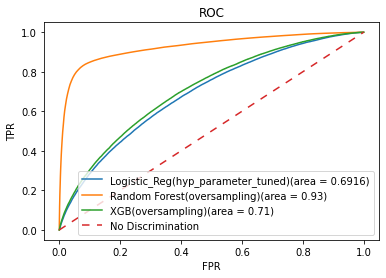

In [ ]:
for key in roc_dict:
    clf = roc_dict[key]
    plt.plot(clf['fpr'], clf['tpr'], label=key)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.legend()
plt.show()